In [3]:
from IPython.display import clear_output
!pip install tensorflow==2.7.0
clear_output()

In [4]:
from IPython.display import clear_output
!pip install imageio
clear_output()

In [5]:
import numpy as np 
import sympy as sp
import pandas as pd
import tensorflow as tf
from h5py import File as HDF5File
from PIL import Image
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import imageio
from IPython import display

2022-09-22 16:15:21.166013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-09-22 16:15:21.166084: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
import os
os.chdir(r'/kaggle/working')

In [7]:
jet_mass_datafile = '../input/qgans-jet-mass-dataset/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_mass_datafile, 'r')

In [8]:
print(jet_mass_data.keys())

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>


(872666, 25, 25)


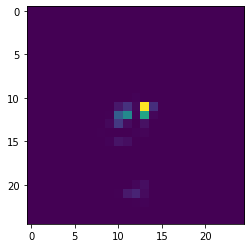

In [9]:
X_jet = jet_mass_data['image']
print(X_jet.shape)
plt.imshow(X_jet[5,:,:])

In [10]:
X_jet = X_jet[:100000,:,:]
print(X_jet.shape)

(100000, 25, 25)


Maximum pixel value for Jet mass images: 312
(100000, 16, 16)


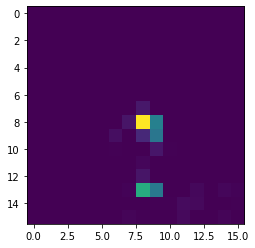

In [11]:
max_val_pix = np.argmax(np.mean(X_jet[:, :, :], axis=0))
print("Maximum pixel value for Jet mass images:",max_val_pix)
center = [int(max_val_pix/25), max_val_pix%25]

img_size = 16
X_jet = X_jet[:, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]

print(X_jet.shape)
plt.imshow(X_jet[0,:,:])

In [12]:
def plot_jet_image(content,
#                     output_name,
                    vmin=1e-6,
                    vmax=300,
                    title=''):
    fig, ax = plt.subplots(figsize=(7, 6))
    extent=[-1.25, 1.25, -1.25, 1.25]
    im = ax.imshow(content, interpolation='nearest', norm=LogNorm(vmin=vmin, vmax=vmax), extent=extent)
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $p_T$ (GeV)', y=0.85)
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
    plt.title(title)

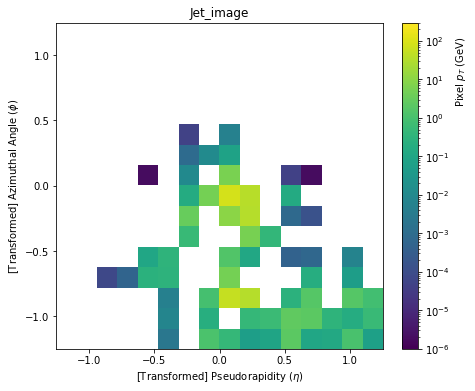

In [13]:
plot_jet_image(X_jet[0,:,:],title = 'Jet_image')

In [15]:
def create_discriminator_classical():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[16, 16, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (2, 2), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(64, (2, 2), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

In [16]:
def create_generator_classical():
    model = tf.keras.Sequential()
    # foundation for 2x2 image
    n_nodes = 64 * 4 * 4
    model.add(tf.keras.layers.Dense(n_nodes, use_bias=False, input_shape=(80,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((4, 4, 64)))

    model.add(tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(1,1), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

#     model.add(tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(1,1), padding="same", use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
    
    # upsample to 4x4
    model.add(tf.keras.layers.Conv2DTranspose(8, (2,2), strides=(2,2), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())    
    # upsample to 8x8
    model.add(tf.keras.layers.Conv2DTranspose(1, (3,3), strides=(2,2), padding="same", use_bias=False, activation='tanh'))
    return model

In [17]:
# with strategy.scope():
discriminator_model = create_discriminator_classical()
generator_model = create_generator_classical()
generator_model.summary()
discriminator_model.summary()

2022-09-22 16:17:47.201124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-09-22 16:17:47.201188: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-22 16:17:47.201221: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1817604f6930): /proc/driver/nvidia/version does not exist
2022-09-22 16:17:47.201844: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1024)              81920     
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 16)         4096      
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 16)        

In [18]:
discriminator_model.input_shape

(None, 16, 16, 1)

In [19]:
class QGAN():
  def __init__(self,discriminator,generator,disc_optimizer,gen_optimizer):
    self.generator_model = generator
    self.discriminator_model = discriminator
    self.d_opt = disc_optimizer
    self.g_opt = gen_optimizer
    # self.g_lr = gen_learning_rate
    # self.d_lr = disc_learning_rate
    self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.gen_loss_ = []
    self.disc_loss_ = []
    self.epochs_ = []
    # self.d_opt = self.d_opt(self.d_lr)
    # self.g_opt = self.g_opt(self.g_lr)

  def prepare_dataset(self,data,batch_size,seed=None,drop_remainder=True,buffer_size=100):
    buffer_size =len(data[0])
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.shuffle(buffer_size=buffer_size,seed=seed,reshuffle_each_iteration=True)
    ds = ds.batch(batch_size,drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

  def train_preprocess(self,random_state):
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
  
  @tf.function
  def generator_loss(self,fake_output):
    return self.loss(tf.ones_like(fake_output),fake_output)

  @tf.function
  def discriminator_loss(self,real_output,fake_output):
    real_loss = self.loss(tf.ones_like(real_output),real_output)
    fake_loss = self.loss(tf.zeros_like(fake_output),fake_output)
    return real_loss + fake_loss
  
  @tf.function
  def train_step_1v1(self,x_real,batch_size):
    """Training step for one epoch with 1 generator step and 1 discriminator step
        """
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      x_fake_ = self.generator_model(z, training=True)
      # x_fake = tf.reshape(x_fake_, tf.shape(x_real))
      real_output = self.discriminator_model(x_real, training=True)
      fake_output = self.discriminator_model(x_fake_, training=True)
      gen_loss = self.generator_loss(fake_output)
      disc_loss = self.discriminator_loss(real_output, fake_output)
    grad_gen = gen_tape.gradient(gen_loss, self.generator_model.trainable_variables)
    grad_disc = disc_tape.gradient(disc_loss, self.discriminator_model.trainable_variables)
    self.g_opt.apply_gradients(zip(grad_gen, self.generator_model.trainable_variables))
    self.d_opt.apply_gradients(zip(grad_disc, self.discriminator_model.trainable_variables))  
    return gen_loss, disc_loss

  @tf.function
  def train_step_nv1(self,x_real,n_disc,batch_size):
    for i in range(n_disc):
      x_real_batch = tf.gather(x_real,i)
      d_loss = self.discriminator_step(x_real_batch,batch_size)
    g_loss = self.generator_step(batch_size)
    return g_loss, d_loss

  @tf.function
  def train_step_1vn(self,x_real,n_gen,batch_size):
    for i in range(n_gen):
      g_loss = self.generator_step(batch_size)
    d_loss = self.discriminator_step(x_real,batch_size)
    return g_loss, d_loss 

  @tf.function
  def discriminator_step(self,x_real,batch_size):
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gradient_tape:
      real_output = self.discriminator_model(x_real,training = True)
      fake_input = self.generator_model(z, training = True) 
      # fake_input = tf.reshape(fake_input, tf.shape(x_real))
      fake_output = self.discriminator_model(fake_input,training = True)
      cost = self.discriminator_loss(real_output,fake_output)
    grad = gradient_tape.gradient(cost,self.discriminator_model.trainable_variables)
    self.d_opt.apply_gradients(zip(grad,self.discriminator_model.trainable_variables))
    return cost

  @tf.function
  def generator_step(self,batch_size):
    fake_data_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(shape=fake_data_shape)
    with tf.GradientTape() as gradient_tape:
      fake_input = self.generator_model(z,training=True)
      fake_output = self.discriminator_model(fake_input,training= True) #
      loss = self.generator_loss(fake_output)
    grad = gradient_tape.gradient(loss,self.generator_model.trainable_variables)
    self.g_opt.apply_gradients(zip(grad,self.generator_model.trainable_variables))
    return loss
  
  def train_qgans(self,x,epochs,batch_size,seed=1024,n_disc=1,n_gen=1):
    input_shape = x.shape[1:]
    self.train_preprocess(seed)
    data = self.prepare_dataset(data=x,batch_size=batch_size*n_disc,seed=seed)
    g_metric = tf.keras.metrics.Mean()
    d_metric = tf.keras.metrics.Mean()
    for epoch in range(epochs):
      for step,training_batch_data_ in enumerate(data):
        if( n_disc == 1 and n_gen == 1):
          input_batch_shape = (batch_size,) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
          gen_loss,disc_loss = self.train_step_1v1(x_real=training_batch_data, batch_size=batch_size)
          display.clear_output(wait=True)
          generate_and_save_images(self.generator_model,epoch + 1,batch_size)
        if n_disc > 1 and n_gen == 1:
          input_batch_shape = (n_disc, batch_size) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
          gen_loss,disc_loss = self.train_step_nv1(x_real=training_batch_data, batch_size=batch_size,n_disc=n_disc)
          display.clear_output(wait=True)
          generate_and_save_images(self.generator_model,epoch + 1,batch_size)
        if n_gen > 1 and n_disc == 1:
          input_batch_shape = (batch_size,) + input_shape
          training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
          gen_loss,disc_loss = self.train_step_1vn(x_real=training_batch_data, batch_size=batch_size,n_gen=n_gen)
          display.clear_output(wait=True)
          generate_and_save_images(self.generator_model,epoch + 1,batch_size)
        g_metric(gen_loss)
        d_metric(disc_loss)
     
      self.gen_loss_.append(g_metric.result().numpy())
      self.disc_loss_.append(d_metric.result().numpy())
      self.epochs_.append(epoch)
      print("Epoch:{} ;   generator_loss:{} ;   discriminator_loss:{}".format(epoch,g_metric.result().numpy(),d_metric.result().numpy()))
  
      g_metric.reset_state()
      d_metric.reset_state()
    display.clear_output(wait=True)
    return self.gen_loss_,self.disc_loss_,self.epochs_

  def generate_samples(self,batch_size, shape=None):
    """Generates sample using random inputs
        
            Arguments:
                batch_size: int
                    Number of samples to generate.
                shape: (Optional) tuple of int
                    Reshape the output to the given shape.
        """
    z_batch_shape = (batch_size,) + self.generator_model.input_shape[1:]
    z = tf.random.normal(z_batch_shape)
    print(z.shape[0])
    samples = self.generator_model(z,training = False)
    # samples = generator_model
    # if shape is not None:
    #   shape = (batch_size,) + shape
    #   samples = tf.reshape(samples, shape)
    return samples

  def predict(self, x):
    return self.discriminator_model(x, training=False)

In [20]:
def generate_and_save_images(model, epoch, batch_size):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  z_batch_shape = (batch_size,) + model.input_shape[1:]
  z = tf.random.normal(z_batch_shape) 
  predictions = model(z, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(4):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
fake_data_shape = (10000,) + generator_model.input_shape[1:]
print(fake_data_shape)
print(generator_model.output_shape)
print(discriminator_model.input_shape)

(10000, 80)
(None, 16, 16, 1)
(None, 16, 16, 1)


In [22]:
d_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
g_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
model = QGAN(generator=generator_model,discriminator=discriminator_model,disc_optimizer=d_optimizer,gen_optimizer=g_optimizer)

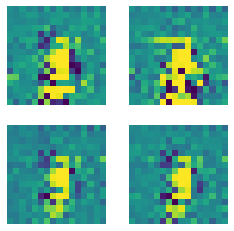

Epoch:139 ;   generator_loss:0.7346178293228149 ;   discriminator_loss:0.6857249140739441


In [22]:
X_jet = np.reshape(X_jet, (X_jet.shape[0], 16, 16, 1))
gen_loss_,disc_loss_,epochs_ = model.train_qgans(X_jet,epochs=140,batch_size=20000,seed=2021,n_gen=10)

In [23]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_loss(gen_loss,disc_loss,epochs):
  fig = plt.figure(figsize=(16,9))
  gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
  epoch = epochs[-1]
  # plot loss curve
  ax_loss = plt.subplot(gs[:,:4])
  ax_loss.set_xlim(0, 1.1*epoch)
  ax_loss.plot(epochs, gen_loss, label="Generator")
  ax_loss.plot(epochs, disc_loss, label="Discriminator")
  ax_loss.set_xlabel('Epoch', fontsize=20)
  ax_loss.set_ylabel('Loss', fontsize=20)
  ax_loss.grid(True)
  ax_loss.legend(fontsize=15)

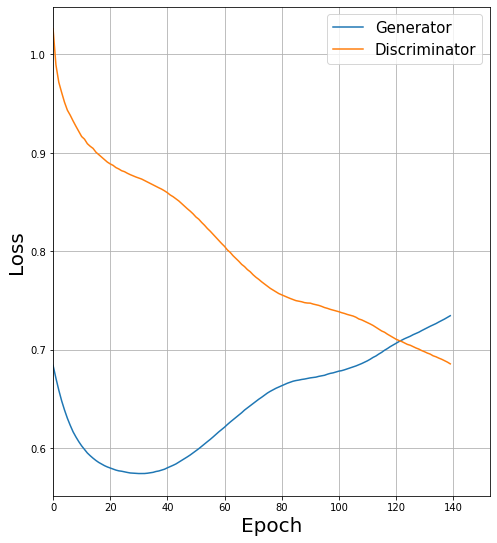

In [24]:
plot_loss(gen_loss_,disc_loss_,epochs_)

8


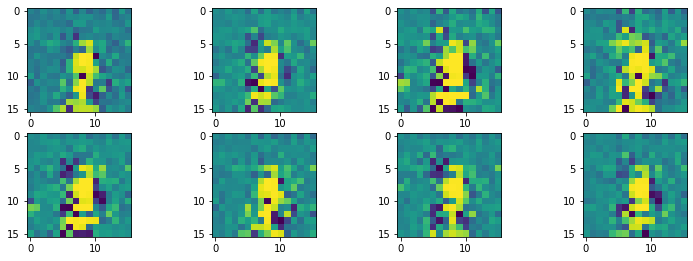

In [25]:
n_images = 8
samples = np.reshape(np.array(model.generate_samples(batch_size=n_images,shape=(5,))),(n_images,16,16))
fig = plt.figure(figsize=(26,18))
gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
for i in range(samples.shape[0]):
  ax = plt.subplot(gs[i//4, 4 + i%4])
  plt.imshow(samples[i])

In [26]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

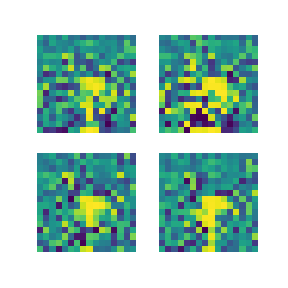

In [27]:
display_image(100)

In [28]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

print(type(anim_file))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys


<class 'str'>


In [2]:
from IPython.display import HTML

HTML('<img src="./dcgan.gif" />')